In [13]:
# パッケージのインポート
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

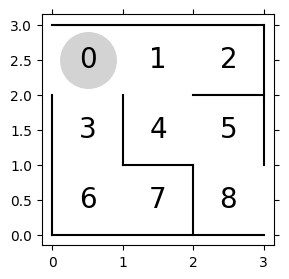

In [14]:
# 迷路の作成
fig = plt.figure(figsize=(3, 3))

# 壁
plt.plot([0, 3], [3, 3], color='k')
plt.plot([0, 3], [0, 0], color='k')
plt.plot([0, 0], [0, 2], color='k')
plt.plot([3, 3], [1, 3], color='k')
plt.plot([1, 1], [1, 2], color='k')
plt.plot([2, 3], [2, 2], color='k')
plt.plot([2, 1], [1, 1], color='k')
plt.plot([2, 2], [0, 1], color='k')

# 数字
for i in range(3):
    for j in range(3):
        plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha='center', va='center')

# 円
circle, = plt.plot([0.5], [2.5], marker='o', color='#d3d3d3', markersize=40)

# 目盛りと枠の非表示
plt.tick_params(axis='both', which='both', bottom='off', top= 'off',
        labelbottom='off', right='off', left='off', labelleft='off')
plt.box('off')

In [15]:
# パラメータθの初期値の準備
theta_0 = np.array([
    [np.nan, 1, 1, np.nan], # 0 上,右,下,左
    [np.nan, 1, 1, 1], # 1
    [np.nan, np.nan, np.nan, 1], # 2
    [1, np.nan, 1, np.nan], # 3
    [1, 1, np.nan, np.nan], # 4
    [np.nan, np.nan, 1, 1], # 5
    [1, 1, np.nan, np.nan], # 6
    [np.nan, np.nan, np.nan, 1]]) # 7

In [16]:
# パラメータθを方策に変換
def get_pi(theta):
    # ソフトマックス関数で変換
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    exp_theta = np.exp(theta)
    for i in range(0, m):
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
    pi = np.nan_to_num(pi)
    return pi

In [17]:
# パラメータθの初期値を方策に変換
pi_0 = get_pi(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.         1.        ]]


In [18]:
# 方策に従って行動を取得
def get_a(pi, s):
    # 方策の確率に従って行動を返す
    return np.random.choice([0, 1, 2, 3], p=pi[s])

In [19]:
# 行動に従って次の状態を取得
def get_s_next(s, a):
    if a == 0: # 上
        return s - 3
    elif a == 1: # 右
        return s + 1
    elif a == 2: # 下
        return s + 3
    elif a == 3: # 左
        return s - 1

In [20]:
# 1エピソード実行して履歴取得
def play(pi):
    s = 0 # 状態
    s_a_history = [[0, np.nan]] # 状態と行動の履歴
    
    # エピソード完了までループ
    while True:
        # 方策に従って行動を取得
        a = get_a(pi, s)
        
        # 行動に従って次の状態を取得
        s_next = get_s_next(s, a)
        
        # 履歴の更新
        s_a_history[-1][1] = a     
        s_a_history.append([s_next, np.nan]) 
        
        # 終了判定
        if s_next == 8:
            break
        else:
            s = s_next
            
    return s_a_history

In [21]:
# 1エピソードの実行と履歴の確認
s_a_history = play(pi_0)
print(s_a_history)
print('1エピソードのステップ数：{}'.format(len(s_a_history)+1))

[[0, 2], [3, 0], [0, 1], [1, 3], [0, 1], [1, 2], [4, 0], [1, 1], [2, 3], [1, 3], [0, 1], [1, 3], [0, 2], [3, 2], [6, 0], [3, 0], [0, 1], [1, 3], [0, 2], [3, 2], [6, 0], [3, 2], [6, 0], [3, 0], [0, 1], [1, 3], [0, 1], [1, 1], [2, 3], [1, 2], [4, 1], [5, 2], [8, nan]]
1エピソードのステップ数：34


In [22]:
def update_theta(theta, pi, s_a_history):
    eta = 0.1 # 学習係数
    total = len(s_a_history) - 1 # ゴールまでにかかった総ステップ数
    [s_count, a_count] = theta.shape # 状態数, 行動数

    # パラメータθの変化量の計算
    delta_theta = theta.copy()
    for i in range(0, s_count):
        for j in range(0, a_count):
            if not(np.isnan(theta[i, j])):
                # ある状態である行動を採る回数
                sa_ij = [sa for sa in s_a_history if sa == [i, j]]
                n_ij = len(sa_ij)

                # ある状態でなんらかの行動を採る回数
                sa_i = [sa for sa in s_a_history if sa[0] == i]
                n_i = len(sa_i)

                # パラメータθの変化量
                delta_theta[i, j] = (n_ij - pi[i, j] * n_i) / total

    # パラメータθの更新
    return theta + eta * delta_theta

In [23]:
stop_epsilon = 10**-4 # しきい値
theta = theta_0 # パラメータθ
pi = pi_0 # 方策

# エピソードを繰り返し実行して学習
for episode in range(10000):
    # 1エピソード実行して履歴取得
    s_a_history = play(pi)
    
    # パラメータθの更新
    theta = update_theta(theta, pi, s_a_history)
    
    # 方策の更新
    pi_new = get_pi(theta)
    
    # 方策の変化量
    pi_delta = np.sum(np.abs(pi_new-pi))
    pi = pi_new    
    
    # 出力
    # print('エピソード: {}, ステップ： {}, 方策変化量: {:.4f}'.format(
    #     episode, len(s_a_history)-1, pi_delta))
    
    # 終了判定
    if pi_delta < stop_epsilon: # 方策の変化量がしきい値以下
        break

In [24]:
# アニメーションの定期処理を行う関数
def animate(i):
    state = s_a_history[i][0]
    circle.set_data((state % 3) + 0.5, 2.5 - int(state / 3))
    return circle

# アニメーションの表示
anim = animation.FuncAnimation(fig, animate, \
        frames=len(s_a_history), interval=200, repeat=False)
HTML(anim.to_jshtml())